In [72]:
# %%capture
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import time
from matplotlib import gridspec

path_to_vape = os.path.expanduser('~/Documents/code/Vape')
sys.path.append(path_to_vape)
sys.path.append(os.path.join(path_to_vape, 'utils'))
import utils_funcs as utils

from Session import Session, Session_lite

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
# global plotting params
sns.set()
sns.set_style('white')
params = {'legend.fontsize': 'xx-large',
          'text.usetex':False,
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}

plt.rc("axes.spines", top=False, right=False) # despine

plt.rcParams.update(params)

In [45]:
def get_frames_use(session, times_use):

    frames_use = []
    for tt in times_use:
        # this will throw an error if tt not in filter_ps_time
        frames = session.filter_ps_array[np.where(session.filter_ps_time == tt)[0][0]]
        frames_use.append(frames)
        
    assert len(times_use) == len(frames_use) 
    return np.array(frames_use)

In [46]:
## Integrate different imaging frequencies:
def get_tp_dict(sessions):
    freqs = np.unique([ss.frequency for _, ss in sessions.items()])
    tp_dict = {}
    for ff in freqs:
        for _, ss in sessions.items():   # assume pre_seconds & post_seconds equal for all sessions
            if ss.frequency == ff:
                tp_dict[ff] = ss.filter_ps_time
    if len(freqs) == 2:  # for hard-coded bit next up
        tp_dict['mutual'] = np.intersect1d(ar1=tp_dict[freqs[0]], ar2=tp_dict[freqs[1]])
    elif len(freqs) == 1:
        tp_dict['mutual'] = tp_dict[freqs[0]]
    
    return tp_dict

In [47]:
def load_sessions(flu_flavour):
    
    base_path = os.path.expanduser('~/Documents/code/')
    if flu_flavour == 'denoised_flu':
        sessions_file = 'sessions_lite_denoised_flu.pkl'
    elif flu_flavour == 'flu':
        sessions_file = 'sessions_lite_flu.pkl'
    elif flu_flavour == 'spks':
        sessions_file = 'sessions_lite_spks.pkl'
    else:
        raise ValueError('flu_flavour not recognised')
        
    sessions_path = os.path.join(base_path, sessions_file)
                             
    with open(sessions_path, 'rb') as f:
        sessions = pickle.load(f)
        
    # Find the frames to use that match across all sessions
    baseline_start = -2
    tp_dict = get_tp_dict(sessions)
    times_use = tp_dict['mutual']
    times_use = times_use[times_use >= baseline_start]

    for idx, session in sessions.items():
        session.frames_use = get_frames_use(session, times_use)
        
    return sessions

In [48]:
def session_stacker(sessions, cells_include='s1', prereward=False, sub_baseline=True):
   
    for idx, session in sessions.items():
        
        
        if cells_include == 's1':
            cell_bool = session.s1_bool#[session.filtered_neurons]
        elif cells_include == 's2':
            cell_bool = session.s2_bool#[session.filtered_neurons]
        
        if not prereward:
            behaviour_trials = session.behaviour_trials[cell_bool, :, :]
        else:
            behaviour_trials = session.pre_rew_trials[cell_bool, :, :]
        
        baseline_frames = np.where((session.filter_ps_time>=-2) & (session.filter_ps_time<0))[0]
        baseline = np.mean(behaviour_trials[:, :, baseline_frames], 2)
        
        if sub_baseline:
            baseline_subbed = behaviour_trials[:, :, session.frames_use] - baseline[:,:,np.newaxis]
        else:
            baseline_subbed = behaviour_trials[:, :, session.frames_use]
        
        if idx == 0:
            stacked_trials = np.mean(baseline_subbed, 0)
        else:
            stacked_trials = np.vstack((stacked_trials, np.mean(baseline_subbed, 0)))
        
    return stacked_trials

In [49]:
def tt_idxs(session, trial_type='all', trial_outcome='all'):
    
    assert len(session.photostim) == len(session.decision)

    if trial_type == 'nogo':
        type_use = session.photostim == 0
    elif trial_type == 'test':
        type_use = session.photostim == 1
    elif trial_type == 'easy':
        type_use = session.photostim == 2
    elif trial_type == 'all':
        type_use = np.repeat(True, len(session.photostim))
        
    if trial_outcome == 'hit' or trial_outcome=='fp':
        outcome_use = np.logical_and(session.decision == 1, session.unrewarded_hits==False)
    elif trial_outcome == 'miss' or trial_outcome=='cr':
        outcome_use = np.logical_and(session.decision == 0, session.autorewarded==False)
    elif trial_outcome == 'ar_miss':
        outcome_use = session.autorewarded
    elif trial_outcome == 'ur_hit':
        outcome_use = session.unrewarded_hits
    elif trial_outcome == 'all':
        outcome_use = np.repeat(True, len(session.decision)) 
        
    return np.logical_and(type_use, outcome_use)

In [50]:
def tt_raveled(sessions, trial_type='all', trial_outcome='all'):
    
    trials_use = []
    
    for idx, session in sessions.items():
        trials_use.append(tt_idxs(session, trial_type, trial_outcome))
        
    return np.concatenate(trials_use)

In [51]:
def average_trace_plotter(df_plot, tt):
    
    color_tt = {'hit': 'green', 'miss': 'grey', 'fp': 'magenta', 'cr': 'brown', 
                'ur_hit': '#7b85d4', 'ar_miss': '#e9d043', 'spont_rew': 'darkorange'}

    sns.lineplot(data=df_plot[df_plot['timepoint'] <= 0], x='timepoint', y='diff_dff', linewidth=3,
                     color=color_tt[tt], label=tt, ci=95)
    sns.lineplot(data=df_plot[df_plot['timepoint'] >= 0], x='timepoint', y='diff_dff', linewidth=3,
                     color=color_tt[tt], label=None, ci=95)
        


In [62]:
def plotting_df(stacked_trials, stacked_prereward=None):
    
    outcomes = ['hit', 'miss', 'ur_hit', 'ar_miss', 'spont_rew', 'cr', 'fp']
    outcomes = ['hit', 'miss', 'spont_rew', 'cr', 'fp']
    #outcomes = ['miss']
    
    tt_mapper = {
        'hit': 'test',
        'miss': 'test',
        'ur_hit': 'test',
        'ar_miss': 'test',
        'spont_rew': None,
        'cr': 'nogo',
        'fp': 'nogo'
    }

    for outcome in outcomes:
        
        if outcome=='spont_rew':
            assert stacked_prereward is not None
            diff_dff = stacked_prereward
        else:
            trials_use = tt_raveled(sessions, tt_mapper[outcome], outcome)
            diff_dff = stacked_trials[trials_use, :]
        
        d = {name: np.array([]) for name in ['diff_dff', 'timepoint']}  
        d['diff_dff'] = diff_dff.ravel()
        d['timepoint'] = np.tile(times_use, diff_dff.shape[0])

        df_plot = pd.DataFrame(d) 
        
        average_trace_plotter(df_plot, outcome)

In [63]:
def plotting_tuple(sessions, region):
    behaviour = session_stacker(sessions, region, prereward=False)
    prereward = session_stacker(sessions, region, prereward=True)
    
    return behaviour, prereward

In [75]:
def s1s2_plot(sessions, ylims, flu_flavour, grid):
    
    to_plot = {
    's1': plotting_tuple(sessions, 's1'),
    's2': plotting_tuple(sessions, 's2')
    }

    # PREREWRAD S2 DIFFERNET?
    #plt.figure(figsize=(20, 6))
    plt.subplots_adjust(wspace=0.4,hspace=0.4)
    
    gs = gridspec.GridSpecFromSubplotSpec(1, 2, grid, width_ratios=[1, 1]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    
    for idx, region in enumerate(['s1', 's2']):
        #plt.subplot(1,2,idx+1)
        plt.subplot(gs[idx])
        plotting_df(*to_plot[region])
        
        plt.ylim(ylims)
        plt.title('Average {} response'.format(region))
        plt.axhline(0)
        plt.xlabel('Time (s)')
        
        plt.ylabel(flu_flavour)
        if idx == 0:
            plt.legend(fontsize=14)
        else:
            plt.legend().set_visible(False)
    
    #plt.suptitle(flu_flavour, fontsize=25)

In [76]:
sessions_flu = load_sessions('flu')
sessions_spks = load_sessions('spks')
sessions_denoised = load_sessions('denoised_flu')

/home/jrowland/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/jrowland/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/jrowland/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses t

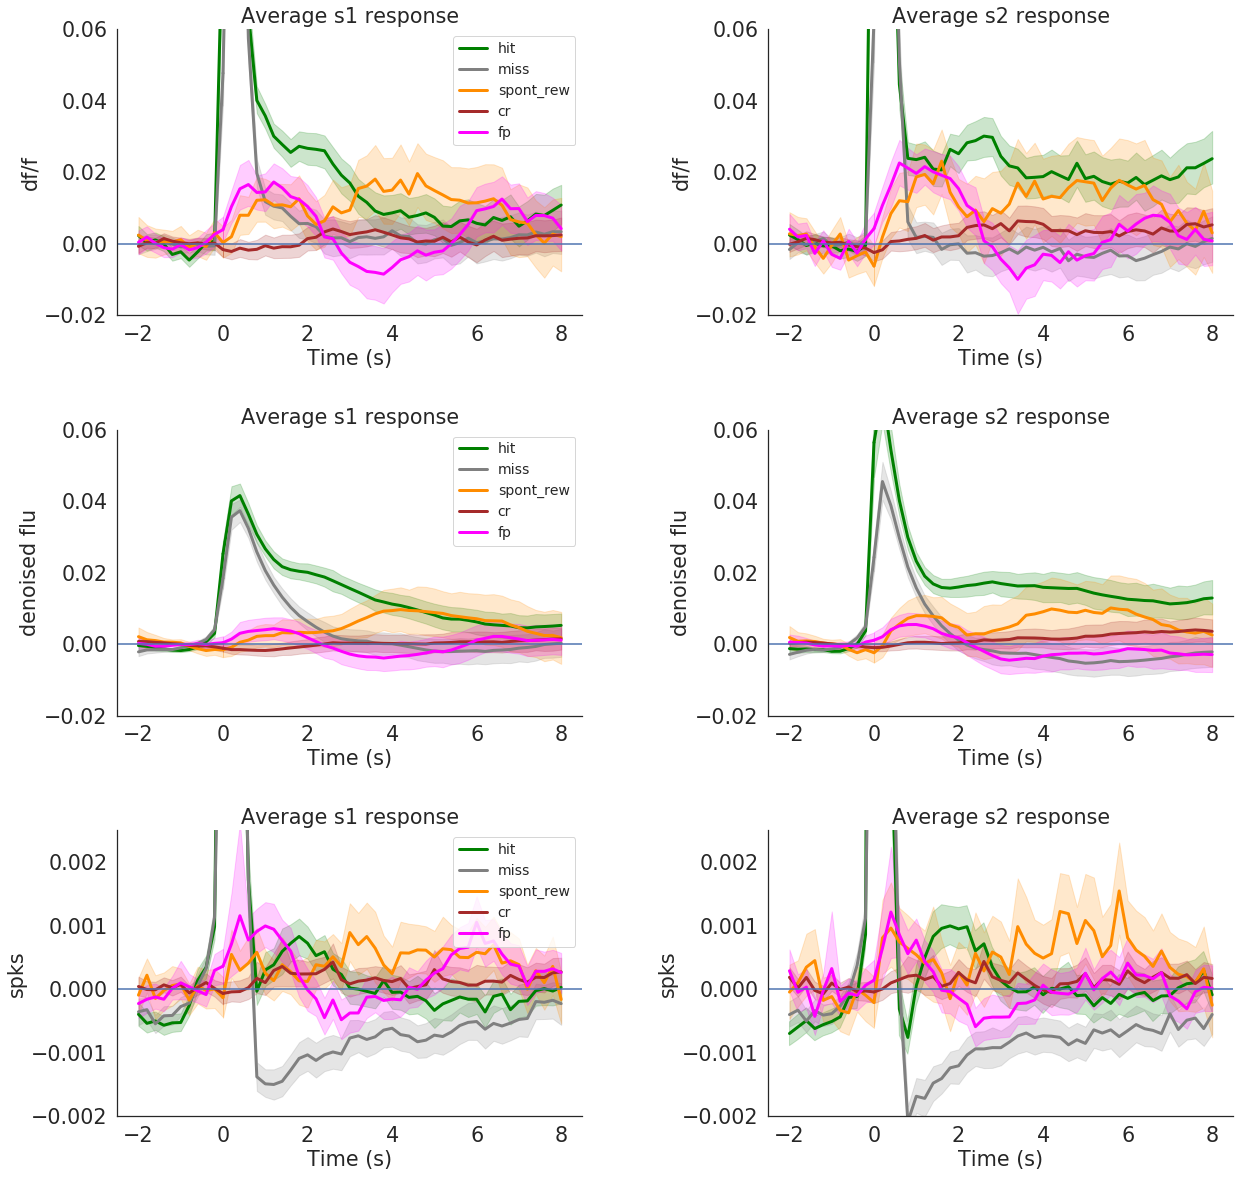

In [83]:
plt.figure(figsize=(20, 20))
outer = gridspec.GridSpec(3,1, hspace=0.4, wspace=0.8)
s1s2_plot(sessions, (-0.02, 0.06), 'df/f', outer[0])
s1s2_plot(sessions_denoised, (-0.02, 0.06), 'denoised flu', outer[1])
s1s2_plot(sessions_spks, (-0.002, 0.0025), 'spks', outer[2])